<center>
    <img src="https://gitlab.com/ibm/skills-network/courses/placeholder101/-/raw/master/labs/module%201/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing\_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data
    \-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression
*   Find the method performs best using test data


***


## Import Libraries and Define Auxiliary Functions


We will import the following libraries for the lab


In [187]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(0)


This function is to plot the confusion matrix.


In [188]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

## Load the dataframe


Load the data


In [189]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")

# If you were unable to complete the previous lab correctly you can uncomment and load this csv

# data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_2.csv')

data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [190]:
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')

# If you were unable to complete the previous lab correctly you can uncomment and load this csv

# X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_3.csv')

X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [191]:
Y = data['Class'].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [192]:
# students get this 
transform = preprocessing.StandardScaler()

X1= transform.fit(X).transform(X)

X[0:2]

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [193]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test= train_test_split( X1, Y, test_size=0.2, random_state=2)
print ('Train set:', X_train.shape,  Y_train.shape )
print ('Test set:', X_test.shape,  Y_test.shape )

Train set: (72, 83) (72,)
Test set: (18, 83) (18,)


we can see we only have 18 test samples.


In [194]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object using then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [195]:
parameters ={'C':[0.01,0.1,1], 'penalty':['l2'], 'solver':['lbfgs']}
lr=LogisticRegression()

In [196]:
logreg_cv=GridSearchCV( lr, parameters, cv=10)
logreg_cv.fit(X_train,Y_train)
logreg_cv

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [197]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


In [198]:
logreg_cv_best=logreg_cv.best_estimator_
print(logreg_cv_best)
logreg_cv_best.score(X_test, Y_test)

LogisticRegression(C=0.01)


0.8333333333333334

## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [199]:
from sklearn import metrics
yhat_lr = logreg_cv.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(Y_train, logreg_cv_best.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(Y_test, yhat_lr))

Train set Accuracy:  0.875
Test set Accuracy:  0.8333333333333334


Lets look at the confusion matrix:


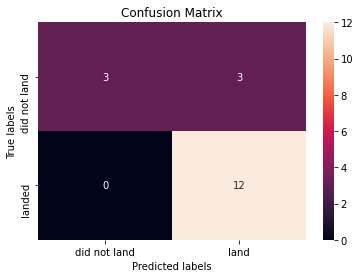

In [200]:
plot_confusion_matrix(Y_test,yhat_lr)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [201]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [202]:
svm_cv=GridSearchCV(svm, parameters,cv=10)
svm_cv.fit(X_train,Y_train)
svm_cv

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [203]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


In [204]:
svm_cv_best=svm_cv.best_estimator_
print(svm_cv_best)
svm_cv_best.score(X_test, Y_test)

SVC(gamma=0.03162277660168379, kernel='sigmoid')


0.8333333333333334

## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [205]:
yhat_svm=svm_cv.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(Y_train, svm_cv_best.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(Y_test, yhat_svm))

Train set Accuracy:  0.8888888888888888
Test set Accuracy:  0.8333333333333334


We can plot the confusion matrix


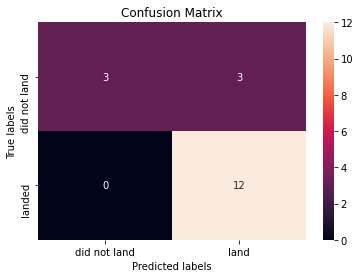

In [206]:
plot_confusion_matrix(Y_test,yhat_svm)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [207]:

parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [208]:
np.random.seed(0)
tree_cv=GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train,Y_train)
tree_cv

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [209]:

print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
accuracy : 0.8892857142857145


In [210]:
tree_cv_best=tree_cv.best_estimator_
print(tree_cv_best)
tree_cv_best.score(X_test, Y_test)

DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10, splitter='random')


0.6666666666666666

## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [211]:

yhat_tree=tree_cv.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(Y_train, tree_cv_best.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(Y_test, yhat_tree))

Train set Accuracy:  0.8194444444444444
Test set Accuracy:  0.6666666666666666


We can plot the confusion matrix


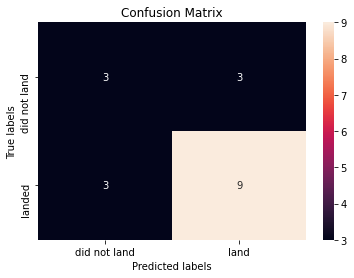

In [212]:
plot_confusion_matrix(Y_test,yhat_tree)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [213]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [214]:
knn_cv=GridSearchCV(KNN, parameters)
knn_cv.fit(X_train,Y_train)
knn_cv

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [215]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 8, 'p': 1}
accuracy : 0.8609523809523811


In [216]:
knn_cv_best=knn_cv.best_estimator_
print(knn_cv_best)
knn_cv_best.score(X_test, Y_test)

KNeighborsClassifier(n_neighbors=8, p=1)


0.8333333333333334

## TASK  11


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [217]:
yhat_knn=knn_cv.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(Y_train, knn_cv_best.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(Y_test, yhat_knn))

Train set Accuracy:  0.8611111111111112
Test set Accuracy:  0.8333333333333334


We can plot the confusion matrix


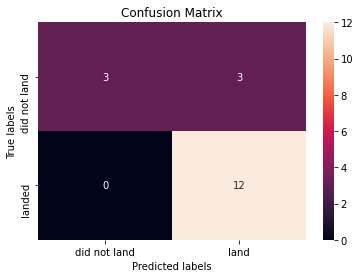

In [218]:
plot_confusion_matrix(Y_test,yhat_knn)

## TASK  12


In [172]:
#To show all values in the columns
pd.set_option('display.max_colwidth', 150)

Find the method performs best:


In [219]:
report=pd.DataFrame([[metrics.accuracy_score(Y_train, logreg_cv_best.predict(X_train)), logreg_cv_best.score(X_test, Y_test), logreg_cv.best_score_, yhat_lr],                       
                    [metrics.accuracy_score(Y_train, svm_cv_best.predict(X_train)), svm_cv_best.score(X_test, Y_test), svm_cv.best_score_, yhat_svm],
                    [metrics.accuracy_score(Y_train, tree_cv_best.predict(X_train)),     tree_cv_best.score(X_test, Y_test), tree_cv.best_score_,  yhat_tree],
                    [metrics.accuracy_score(Y_train, knn_cv_best.predict(X_train)),      knn_cv_best.score(X_test, Y_test), knn_cv.best_score_, yhat_knn]], 
columns=('Train Accuracy Score (.accuracy_score())', 'Test Accuracy Score (.score())','GridSearchCV(.best_score_)', 'Yhat(.predict())'), index=[ 'LogisticRegression', 'SVM', 'Decision Tree', 'KNN'] )
report.rename_axis('Algorithm')

,Train Accuracy Score (.accuracy_score()),Test Accuracy Score (.score()),GridSearchCV(.best_score_),Yhat(.predict())
Algorithm,,,,
LogisticRegression,0.875000,0.833333,0.846429,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]"
SVM,0.888889,0.833333,0.848214,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]"
Decision Tree,0.819444,0.666667,0.889286,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]"
KNN,0.861111,0.833333,0.860952,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]"


Separate the column with the test set accuracy scores of models

In [220]:
models_accuracy=report['Test Accuracy Score (.score())']
models_accuracy1=models_accuracy.copy()
models_accuracy1.sort_values(ascending=False, inplace=True)
models_accuracy1

LogisticRegression    0.833333
SVM                   0.833333
KNN                   0.833333
Decision Tree         0.666667
Name: Test Accuracy Score (.score()), dtype: float64

To İllustrate the performance of the models use bar chart 

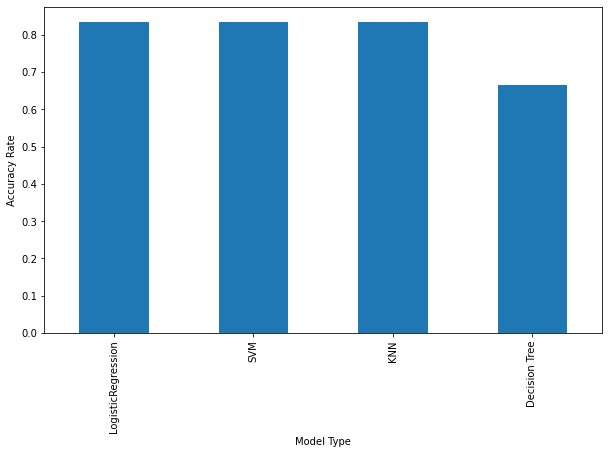

In [221]:
models_accuracy1.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Model Type') # add to x-label to the plot
plt.ylabel('Accuracy Rate') # add y-label to the plot
plt.title('') # add title to the plot

plt.show()

## Authors


<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2021-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description      |
| ----------------- | ------- | ---------- | ----------------------- |
| 2020-09-20        | 1.0     | Joseph     | Modified Multiple Areas |


Copyright © 2020 IBM Corporation. All rights reserved.


Up to now. We get accuracy rates of 4 models with using all the data with 0.2 test size

A = Launches which fulfil the condition of reusedcount>0 have %86 success rate (60 launches in total)

B = Launches which fulfil the condition of payload mass>=6800kg have %88 success rate (26 launches in total)

B is a subset of A

We will test our models prediction performance on dataset B. 


In [222]:
data_try=data[data['PayloadMass']>=6800]
data_try.shape

(26, 18)

Train sets won't be changed 

whole of data_try will be used as test set


In [223]:
Xtry=X[X['PayloadMass']>=6800]
Xtry.reset_index(drop=True, inplace=True)
Xtry.head(5)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,26.0,9600.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,34.0,9600.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,39.0,9600.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,43.0,9600.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,47.0,9600.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [224]:
Ytry=data_try['Class'].to_numpy()
Ytry

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1], dtype=int64)

In [225]:
transform = preprocessing.StandardScaler()
Xtry=transform.fit(Xtry).transform(Xtry)
Xtry.shape

(26, 83)

### Logistic Regression Model

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713
LogisticRegression(C=0.01)
Train set Accuracy:  0.875
Test set Accuracy:  0.8461538461538461


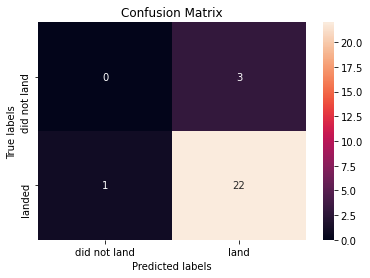

In [227]:
parameters ={'C':[0.01,0.1,1], 'penalty':['l2'], 'solver':['lbfgs']}
lr1=LogisticRegression()
logreg1_cv=GridSearchCV( lr1, parameters, cv=10)
logreg1_cv.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",logreg1_cv.best_params_)
print("accuracy :",logreg1_cv.best_score_)
logreg1_cv_best=logreg1_cv.best_estimator_
print(logreg1_cv_best)
logreg1_cv_best.score(Xtry, Ytry)
from sklearn import metrics
yhat_lr1 = logreg1_cv.predict(Xtry)
print("Train set Accuracy: ", metrics.accuracy_score(Y_train, logreg1_cv_best.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(Ytry, yhat_lr1))
plot_confusion_matrix(Ytry,yhat_lr1)

### Support Vector Machine Model

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856
SVC(gamma=0.03162277660168379, kernel='sigmoid')
Train set Accuracy:  0.8888888888888888
Test set Accuracy:  0.8461538461538461


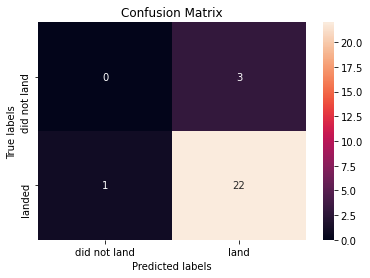

In [228]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm1 = SVC()
svm1_cv=GridSearchCV(svm1, parameters,cv=10)
svm1_cv.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",svm1_cv.best_params_)
print("accuracy :",svm1_cv.best_score_)
svm1_cv_best=svm1_cv.best_estimator_
print(svm1_cv_best)
svm1_cv_best.score(Xtry, Ytry)
yhat_svm1=svm1_cv.predict(Xtry)
print("Train set Accuracy: ", metrics.accuracy_score(Y_train, svm1_cv_best.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(Ytry, yhat_svm1))
plot_confusion_matrix(Ytry,yhat_svm1)

### Decision Tree Model

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
accuracy : 0.8892857142857145
DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10, splitter='random')
Train set Accuracy:  0.8194444444444444
Test set Accuracy:  0.11538461538461539


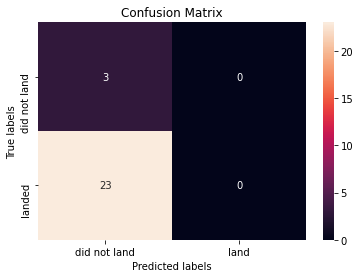

In [229]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}
tree1 = DecisionTreeClassifier()
np.random.seed(0)

tree1_cv=GridSearchCV(tree1, parameters, cv=10)
tree1_cv.fit(X_train,Y_train)
tree1_cv
print("tuned hpyerparameters :(best parameters) ",tree1_cv.best_params_)
print("accuracy :",tree1_cv.best_score_)
tree1_cv_best=tree1_cv.best_estimator_
print(tree1_cv_best)
tree1_cv_best.score(Xtry, Ytry)
yhat_tree1=tree1_cv.predict(Xtry)
print("Train set Accuracy: ", metrics.accuracy_score(Y_train, tree1_cv_best.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(Ytry, yhat_tree1))
plot_confusion_matrix(Ytry,yhat_tree1)

### K NearestNeighbors Model

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 8, 'p': 1}
accuracy : 0.8609523809523811
KNeighborsClassifier(n_neighbors=8, p=1)
Train set Accuracy:  0.8611111111111112
Test set Accuracy:  0.8461538461538461


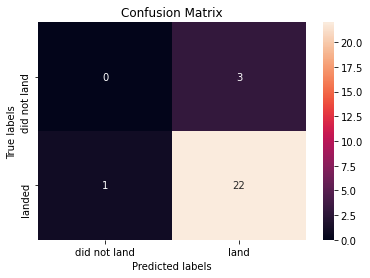

In [230]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN1 = KNeighborsClassifier()
knn1_cv=GridSearchCV(KNN1, parameters)
knn1_cv.fit(X_train,Y_train)
print("tuned hpyerparameters :(best parameters) ",knn1_cv.best_params_)
print("accuracy :",knn1_cv.best_score_)
knn1_cv_best=knn1_cv.best_estimator_
print(knn1_cv_best)
knn1_cv_best.score(Xtry, Ytry)
yhat_knn1=knn1_cv.predict(Xtry)
print("Train set Accuracy: ", metrics.accuracy_score(Y_train, knn1_cv_best.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(Ytry, yhat_knn1))
plot_confusion_matrix(Ytry,yhat_knn1)

In [231]:
report1=pd.DataFrame([[metrics.accuracy_score(Y_train, logreg1_cv_best.predict(X_train)), logreg1_cv_best.score(Xtry, Ytry), logreg1_cv.best_score_, yhat_lr1],                       
                    [metrics.accuracy_score(Y_train, svm1_cv_best.predict(X_train)), svm1_cv_best.score(Xtry, Ytry), svm1_cv.best_score_, yhat_svm1],
                    [metrics.accuracy_score(Y_train, tree1_cv_best.predict(X_train)),     tree1_cv_best.score(Xtry, Ytry), tree1_cv.best_score_,  yhat_tree1],
                    [metrics.accuracy_score(Y_train, knn1_cv_best.predict(X_train)),      knn1_cv_best.score(Xtry, Ytry), knn1_cv.best_score_, yhat_knn1]], 
columns=('Train Accuracy Score (.accuracy_score())', 'Test Accuracy Score (.score())','GridSearchCV(.best_score_)', 'Yhat(.predict())'), index=[ 'LogisticRegression', 'SVM', 'Decision Tree', 'KNN'] )
report1.rename_axis('Algorithm')

,Train Accuracy Score (.accuracy_score()),Test Accuracy Score (.score()),GridSearchCV(.best_score_),Yhat(.predict())
Algorithm,,,,
LogisticRegression,0.875000,0.846154,0.846429,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
SVM,0.888889,0.846154,0.848214,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
Decision Tree,0.819444,0.115385,0.889286,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
KNN,0.861111,0.846154,0.860952,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [ ]:
dictti=[]
dictti2=[]
dictti3=[]
dictti4=[]
dictti5=[]

tree = DecisionTreeClassifier()
criterion=['gini', 'entropy']
splitter=['best', 'random']
max_depth=[2*n for n in range(1,10)]
max_features=['auto', 'sqrt']
min_samples_leaf=[1, 2, 4]
min_samples_split=[2, 5, 10]

In [ ]:
tree_cv=GridSearchCV(tree, parameters, cv=10)
for crt in criterion:
    for spl in splitter:
        for dept in max_depth:
            for fea in max_features:
                for lea in min_samples_leaf:
                    for mspl in min_samples_split:
                        parameters = {'criterion': [crt],
                                      'splitter': [spl],
                                      'max_depth': [dept],
                                      'max_features': [fea],
                                      'min_samples_leaf': [lea],
                                      'min_samples_split': [mspl]}                        

                        tree_cv.fit(X_train,Y_train)
                        tree_cv_best=tree_cv.best_estimator_                        
                        yhat_tree=tree_cv.predict(X_test)                        
                        dictti.append(tree_cv.best_params_)
                        dictti2.append(tree_cv.best_score_)
                        dictti3.append(tree_cv_best)
                        dictti4.append(tree_cv_best.score(X_test, Y_test))
                        dictti5.append(metrics.accuracy_score(Y_test, yhat_tree))

In [ ]:
print('tree_cv_best.score ', max(dictti2))
print('tree_cv_best.score index', dictti2.index(max(dictti2)))      
print('best_params_',dictti[dictti2.index(max(dictti2))])      

In [ ]:
print('best_score_ ', max(dictti4))
print('best_score_ index', dictti4.index(max(dictti4)))      
print('best_estimator_',dictti3[dictti4.index(max(dictti4))])

In [ ]:
print('max accuracy_score ', max(dictti5))
print('accuracy_score index', dictti5.index(max(dictti5)))  

In [ ]:
dictti4[dictti2.index(max(dictti2))]

In [ ]:
dictti5[dictti2.index(max(dictti2))]